# Query Expansion

In [1]:
# Create document chunks for embedding
from pypdf import PdfReader

# Read the PDF file
reader = PdfReader("microsoft_annual_report_2022.pdf")
pdf_texts = [p.extract_text().strip() for p in reader.pages]

# Filter the empty strings
pdf_texts = [text for text in pdf_texts if text]

from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter

character_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""],
    chunk_size=1000,
    chunk_overlap=0
)

character_split_texts = character_splitter.split_text('\n\n'.join(pdf_texts))

token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=256)

# Further split the chunks to prepare for embedding
token_split_texts = []
for text in character_split_texts:
    token_split_texts += token_splitter.split_text(text)

Ignoring wrong pointing object 6 0 (offset 0)
Ignoring wrong pointing object 8 0 (offset 0)
Ignoring wrong pointing object 20 0 (offset 0)
Ignoring wrong pointing object 22 0 (offset 0)
Ignoring wrong pointing object 43 0 (offset 0)
Ignoring wrong pointing object 49 0 (offset 0)
Ignoring wrong pointing object 51 0 (offset 0)
Ignoring wrong pointing object 53 0 (offset 0)
Ignoring wrong pointing object 55 0 (offset 0)
Ignoring wrong pointing object 57 0 (offset 0)
Ignoring wrong pointing object 72 0 (offset 0)
Ignoring wrong pointing object 162 0 (offset 0)
Ignoring wrong pointing object 229 0 (offset 0)
Ignoring wrong pointing object 231 0 (offset 0)
Ignoring wrong pointing object 252 0 (offset 0)
Ignoring wrong pointing object 257 0 (offset 0)
Ignoring wrong pointing object 294 0 (offset 0)
Ignoring wrong pointing object 299 0 (offset 0)
Ignoring wrong pointing object 319 0 (offset 0)
Ignoring wrong pointing object 331 0 (offset 0)
Ignoring wrong pointing object 336 0 (offset 0)
Ignor

In [2]:
# Setup chroma
import chromadb
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

embedding_function = SentenceTransformerEmbeddingFunction()

chroma_client = chromadb.Client()
chroma_collection = chroma_client.create_collection("microsoft_annual_report_2022", embedding_function=embedding_function)

ids = [str(i) for i in range(len(token_split_texts))]

# Add documents to the vectorbase
chroma_collection.add(ids=ids, documents=token_split_texts)
chroma_collection.count()

451

In [3]:
# Setup the OpenAI client for the RAG Operation
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
from gen_ai_hub.proxy.native.openai import chat

llm_model = "gpt-35-turbo"

In [4]:
import umap
import numpy as np
from tqdm import tqdm

# Define the projection function
def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings   

embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

/Users/I758675/Documents/Langchain Projects/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/I758675/Documents/Langchain Projects/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
  0%|          | 0/451 [00:00<?, ?it/s]/Users/I758675/Documents/Langchain Projects/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
  0%|          | 1/451 [00:00<06:00,  1.25it/s]/Users/I758675/Documents/Langchain Projects/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finit

## Expansion with generated answers

In [5]:
# Define a function for the LLM to produce an example answer to a given query
# This is essencially asking the model to pupusefully hallucinate an answer
def augment_query_generated(query):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. Provide an example answer to the given question, that might be found in a document like an annual report. "
        },
        {"role": "user", "content": query}
    ] 
    
    kwargs = dict(model_name=llm_model, messages=messages)
    response = chat.completions.create(**kwargs)
    
    content = response.choices[0].message.content
    return content

In [6]:
# Query the model for a hypothetical answer to a query
original_query = "Was there significant turnover in the executive team?"
hypothetical_answer = augment_query_generated(original_query)

joint_query = f"{original_query} {hypothetical_answer}"
print(joint_query)

Was there significant turnover in the executive team? In the past fiscal year, there was no significant turnover in the executive team. The executive team remained stable with key leaders continuing to provide consistent guidance and strategic direction for the company.


In [7]:
# Send in the query along with the hypothetical answer back to the model
results = chroma_collection.query(query_texts=joint_query, n_results=5, include=['documents', 'embeddings'])
retrieved_documents = results['documents'][0]

for doc in retrieved_documents:
    print(doc)
    print('')

. were unfavorable final outcomes to occur, there exists the possibility of a material adverse impact in our consolidated financial statements for the period in which the effects become reasonably estimable.

. because of its inherent limitations, internal control over financial reporting is not intended to provide absolute assurance that a misstatement of our consolidated financial statements would be prevented or detected. management conducted an evaluation of the effectiveness of our internal control over financial reporting based on the framework in internal control – integrated framework ( 2013 ) issued by the committee of sponsoring organizations of the treadway commission. based on this evaluation, management concluded that the company ’ s internal control over financial reporting was effective as of june 30, 2022. there were no changes in our internal control over financial reporting during the quarter ended june 30, 2022 that have materially affected, or are reasonably likely 

In [8]:
# Project the embeddings of the original query, the joint query and the LLMs results to the UMAP space
retrieved_embeddings = results['embeddings'][0]
original_query_embedding = embedding_function([original_query])
augmented_query_embedding = embedding_function([joint_query])

projected_original_query_embedding = project_embeddings(original_query_embedding, umap_transform)
projected_augmented_query_embedding = project_embeddings(augmented_query_embedding, umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

  0%|          | 0/1 [00:00<?, ?it/s]/Users/I758675/Documents/Langchain Projects/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
  0%|          | 0/1 [00:00<?, ?it/s]/Users/I758675/Documents/Langchain Projects/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
  0%|          | 0/5 [00:00<?, ?it/s]/Users/I758675/Documents/Langchain Projects/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/I758675/Documents/Langchain Projects/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.

(-7.571548962593079, 23.63064577579498, 1.1147564589977264, 11.103480345010757)

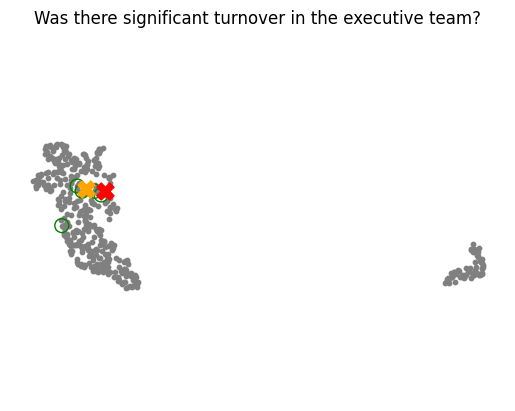

In [ ]:
import matplotlib.pyplot as plt

# Plot the queries and the retrieved documents in the embedding space
# Observe that the augmented query is closer to the retrieved documents
# Meaning that the model has successfully used the hypothetical answer to refine the query
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_augmented_query_embedding[:, 0], projected_augmented_query_embedding[:, 1], s=150, marker='X', color='orange')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

## Expansion with multiple queries

In [10]:
# Define a function to ask the model to generate multiple related uestions based on a given query
def augment_multiple_query(query, model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. Your users are asking questions about an annual report. "
            "Suggest up to five additional related questions to help them find the information they need, for the provided question. "
            "Suggest only short questions without compound sentences. Suggest a variety of questions that cover different aspects of the topic."
            "Make sure they are complete questions, and that they are related to the original question."
            "Output one question per line. Do not number the questions."
        },
        {"role": "user", "content": query}
    ]

    kwargs = dict(model_name=llm_model, messages=messages)
    response = chat.completions.create(**kwargs)
    
    content = response.choices[0].message.content
    content = content.split("\n")
    return content

In [11]:
# Produce multiple related questions based on an original query
original_query = "What were the most important factors that contributed to increases in revenue?"
augmented_queries = augment_multiple_query(original_query)

for query in augmented_queries:
    print(query)

What were the key cost drivers affecting profitability?
What strategies were implemented to grow market share?
Can you provide details on any major investments made during the year?
What were the main challenges faced in the market environment?
How did changes in regulations impact the company's financial performance during the year?


In [12]:
# Query the model with the original query and the augmented queries
# Chroma supports querying in batches
queries = [original_query] + augmented_queries
results = chroma_collection.query(query_texts=queries, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents']

# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

for i, documents in enumerate(retrieved_documents):
    print(f"Query: {queries[i]}")
    print('')
    print("Results:")
    for doc in documents:
        print(doc)
        print('')
    print('-'*100)

Query: What were the most important factors that contributed to increases in revenue?

Results:
. • sales and marketing expenses increased $ 1. 7 billion or 8 % driven by investments in commercial sales and linkedin. sales and marketing included a favorable foreign currency impact of 2 %. • general and administrative expenses increased $ 793 million or 16 % driven by investments in corporate functions. operating income increased $ 13. 5 billion or 19 % driven by growth across each of our segments. current year net income and diluted eps were positively impacted by the net tax benefit related to the transfer of intangible properties, which resulted in an increase to net income and diluted eps of $ 3. 3 billion and $ 0. 44, respectively. prior year net income and diluted eps were positively impacted by the net tax benefit related to the india supreme court decision on withholding taxes, which resulted in an increase to net income and diluted eps of $ 620 million and $ 0. 08, respectively

In [13]:
# Project the original query, the augmented queries and the retrieved documents to the UMAP space
original_query_embedding = embedding_function([original_query])
augmented_query_embeddings = embedding_function(augmented_queries)

project_original_query = project_embeddings(original_query_embedding, umap_transform)
project_augmented_queries = project_embeddings(augmented_query_embeddings, umap_transform)

  0%|          | 0/1 [00:00<?, ?it/s]/Users/I758675/Documents/Langchain Projects/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
  0%|          | 0/5 [00:00<?, ?it/s]/Users/I758675/Documents/Langchain Projects/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/I758675/Documents/Langchain Projects/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/I758675/Documents/Langchain Projects/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warni

In [14]:
result_embeddings = results['embeddings']
# Flatten the list of lists of embeddings
result_embeddings = [item for sublist in result_embeddings for item in sublist]
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)

  0%|          | 0/30 [00:00<?, ?it/s]/Users/I758675/Documents/Langchain Projects/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/I758675/Documents/Langchain Projects/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/I758675/Documents/Langchain Projects/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/I758675/Documents/Langchain Projects/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/I758675/Documents/L

(-7.571548962593079, 23.63064577579498, 1.1147564589977264, 11.103480345010757)

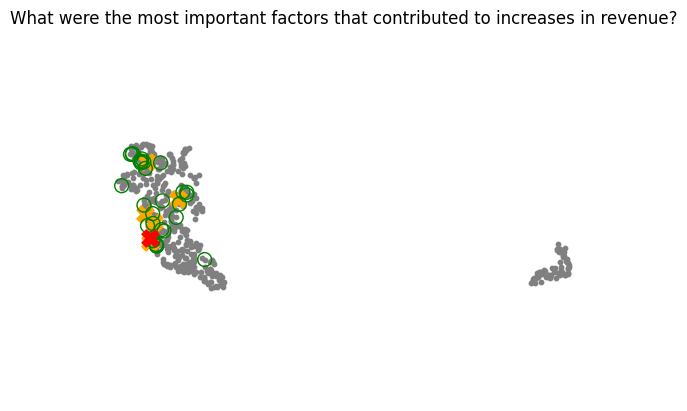

In [ ]:
# Plot the queries and the retrieved documents in the embedding space
# The original query is represented by the red X
# The augmented queries are represented by the orange X
# The retrieved documents are represented by the green circles
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(project_augmented_queries[:, 0], project_augmented_queries[:, 1], s=150, marker='X', color='orange')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1], s=150, marker='X', color='r')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')